In [ ]:
# Cell 1: Imports
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import numpy as np
import PIL.Image
import time
import functools

# Set default display options for matplotlib
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# Cell 2: Image Helper Functions

def load_img(path_to_img):
  """Loads and processes an image for the model."""
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  """Displays an image tensor."""
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

print("Image helper functions defined.")

Image helper functions defined.


Images loaded and displayed successfully.


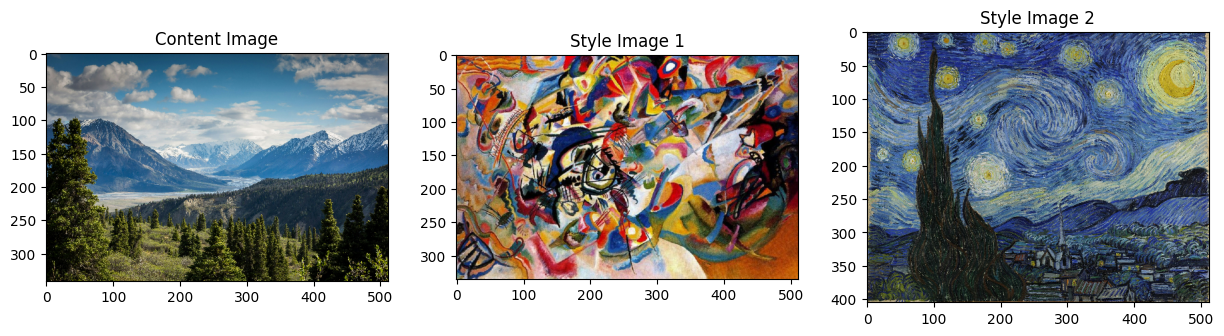

In [ ]:
# Cell 3: Load and Display Images

# Define the file paths for the images you just uploaded
content_path = 'content.jpg'
style_path_1 = 'style1.jpg'
style_path_2 = 'style2.jpg'

# Load the images using our helper function
content_image = load_img(content_path)
style_image_1 = load_img(style_path_1)
style_image_2 = load_img(style_path_2)

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image_1, 'Style Image 1')

plt.subplot(1, 3, 3)
imshow(style_image_2, 'Style Image 2')

print("Images loaded and displayed successfully.")

In [ ]:
# Cell 4: Define the Core Style and Content Model

# --- 1. Define Layer Names ---
# We specify which layers from the VGG19 model to use
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# --- 2. Helper function to create the VGG model ---
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load the VGG19 model, pre-trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# --- 3. Gram Matrix function ---
def gram_matrix(input_tensor):
  """Calculates the Gram matrix (the key to capturing style)."""
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# --- 4. The main StyleContentModel class ---
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculate gram matrix for style outputs
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Package content and style outputs into dictionaries
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

# --- 5. Create an instance of our model ---
extractor = StyleContentModel(style_layers, content_layers)

print("StyleContentModel and extractor defined successfully.")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
StyleContentModel and extractor defined successfully.


In [ ]:
# Cell 5: Define Loss Functions (Novelty 1 & 2)

# --- Novelty 2: Color Preservation Loss ---
def calculate_color_loss(generated_image, content_image):
    """Calculates the loss in color (chrominance)."""
    # Convert images from RGB to YUV color space.
    # Y is luminance (brightness), UV are chrominance (color).
    generated_yuv = tf.image.rgb_to_yuv(generated_image)
    content_yuv = tf.image.rgb_to_yuv(content_image)

    # We only penalize differences in the color channels (U and V),
    # which are at indices 1 and 2.
    color_loss = tf.reduce_mean((generated_yuv[..., 1:3] - content_yuv[..., 1:3])**2)
    return color_loss

# --- Novelty 1: Blended Style & Content Loss ---
def calculate_style_content_loss(outputs, content_targets, style_targets_1, style_targets_2, interpolation_weight):
    """Calculates the blended style loss and the content loss."""

    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # --- Content Loss ---
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # --- Blended Style Loss (Novelty 1) ---
    # 1. Calculate loss against the first style image
    style_loss_1 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_1[name])**2)
                           for name in style_outputs.keys()])

    # 2. Calculate loss against the second style image
    style_loss_2 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_2[name])**2)
                           for name in style_outputs.keys()])

    # 3. Blend the two losses using our interpolation weight
    style_loss = (1.0 - interpolation_weight) * style_loss_1 + interpolation_weight * style_loss_2
    style_loss *= style_weight / num_style_layers

    return content_loss, style_loss

print("Loss functions (calculate_color_loss and calculate_style_content_loss) defined.")

Loss functions (calculate_color_loss and calculate_style_content_loss) defined.


In [28]:
# Cell 6: Set Weights and Define the Main Training Step

# --- 1. Set Weights for all 3 Losses ---
content_weight = 1e4
style_weight = 1e-2

# Weight for Novelty 1: Style Blending
# 0.0 = 100% Style 1, 1.0 = 100% Style 2
interpolation_weight = 0.5

# Weight for Novelty 2: Color Preservation
# 0 = no color preservation
# 1e6 = strong color preservation (a good starting value)
color_weight = 1e6

# --- 2. Pre-calculate Target Features ---
# We run our 3 input images through the extractor once
# to get the "target" feature maps our model will aim for.
content_targets = extractor(content_image)['content']
style_targets_1 = extractor(style_image_1)['style']
style_targets_2 = extractor(style_image_2)['style']

# --- 3. Set up the Optimizer ---
# This algorithm will adjust the image to minimize the loss.
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# --- 4. Define the Main Training Step ---
@tf.function()
def train_step(image):
  """Performs one step of optimization on the image."""
  with tf.GradientTape() as tape:
    # Get the style/content features of our current generated image
    outputs = extractor(image)

    # Calculate our 3 separate losses
    content_loss, style_loss = calculate_style_content_loss(outputs,
                                                            content_targets,
                                                            style_targets_1,
                                                            style_targets_2,
                                                            interpolation_weight)

    color_loss = calculate_color_loss(image, content_image)

    # --- Combine all losses (weighted) ---
    total_loss = content_loss + style_loss + (color_weight * color_loss)

  # Calculate the gradients and apply them to the image
  grad = tape.gradient(total_loss, image)
  opt.apply_gradients([(grad, image)])
  # Clip the image values to keep them between 0 and 1
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

print("Weights and train_step() function defined successfully.")

Weights and train_step() function defined successfully.


Epoch 1/10
....................................................................................................

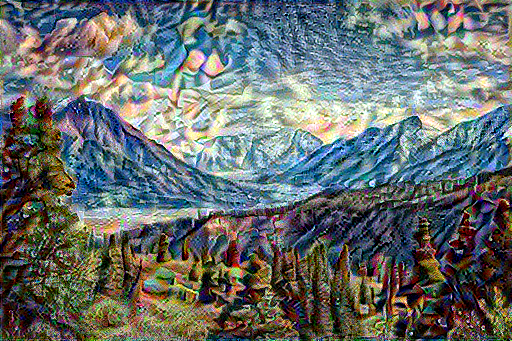

Epoch 2/10
....................................................................................................

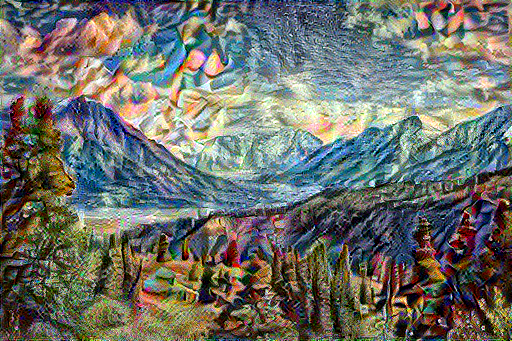

Epoch 3/10
....................................................................................................

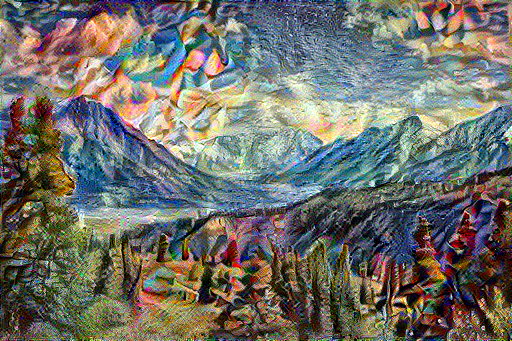

Epoch 4/10
....................................................................................................

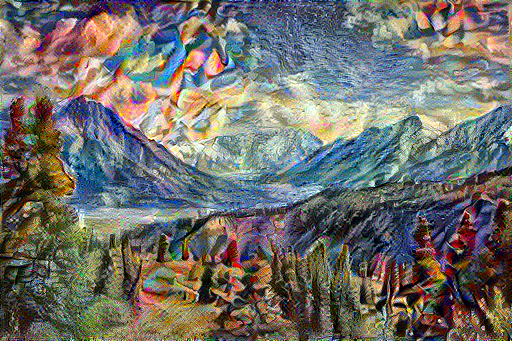

Epoch 5/10
....................................................................................................

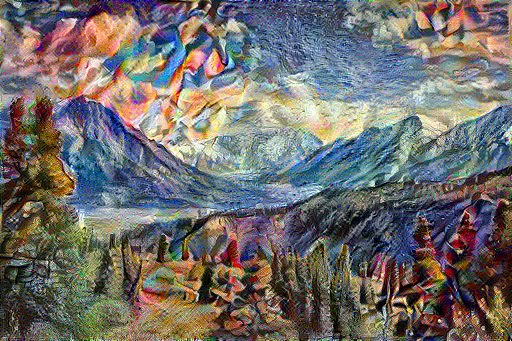

Epoch 6/10
....................................................................................................

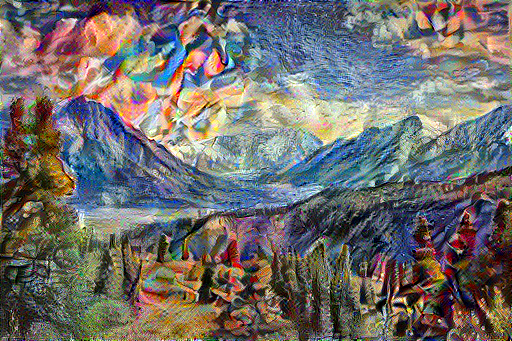

Epoch 7/10
....................................................................................................

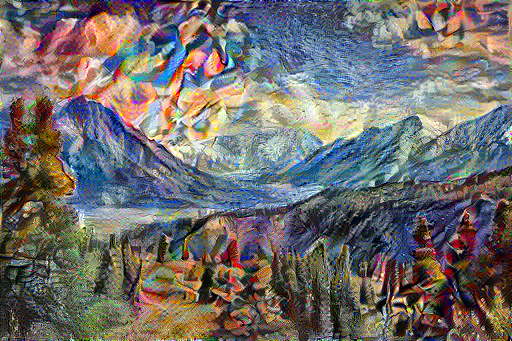

Epoch 8/10
....................................................................................................

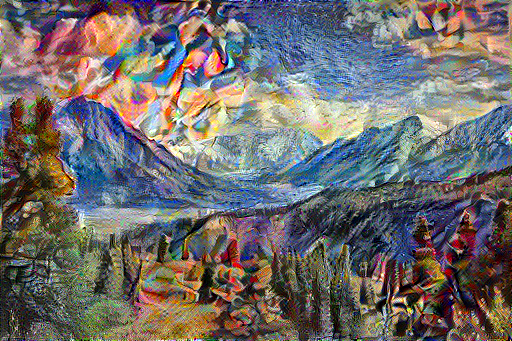

Epoch 9/10
....................................................................................................

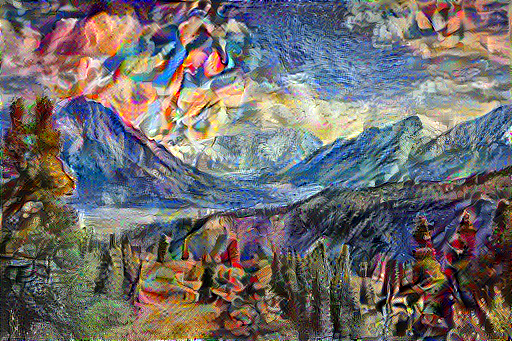

Epoch 10/10
....................................................................................................

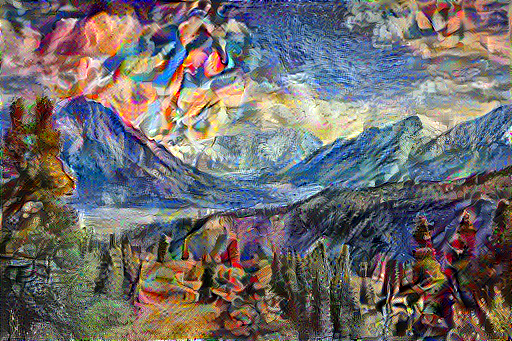


Total time: 67.9 seconds


In [29]:
# Cell 7: Run the Final Optimization Loop

# --- 1. Define final helper functions ---
def tensor_to_image(tensor):
  """Converts a tensor back to a displayable PIL image."""
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# --- 2. Initialize the image to be generated ---
# We start with the content image as our base
image = tf.Variable(content_image)

# --- 3. Run the optimization loop ---
start = time.time()

# You can increase epochs for a higher-quality result
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  print(f"Epoch {n+1}/{epochs}")
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)

  # Display the image at the end of each epoch
  display.display(tensor_to_image(image))
  tensor_to_image(image).save(f"epoch_{n+1}.png")

end = time.time()
print("\nTotal time: {:.1f} seconds".format(end-start))

In [30]:
!ls


content.jpg   epoch_2.png  epoch_5.png	epoch_8.png  style1.jpg
epoch_10.png  epoch_3.png  epoch_6.png	epoch_9.png  style2.jpg
epoch_1.png   epoch_4.png  epoch_7.png	sample_data


In [31]:
# Import the Google Colab files library
from google.colab import files

# Tell it to download our final image
files.download('epoch_10.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>